In [1]:
# import data
RATINGS = "data/movie_dataset/ratings_small.csv"

In [2]:
#!pip3 install numba
import numba

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from math import sqrt

In [4]:
df_rat = pd.read_csv(RATINGS)
df_rat.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [5]:
len(df_rat.movieId.unique()), df_rat.shape, df_rat.rating.mean()

(9066, (100004, 4), 3.543608255669773)

In [6]:
df_count = df_rat.groupby('userId').count()[['movieId']].rename(columns={'movieId':'count'}).reset_index()


In [69]:
test, train = [],[]
for u in df_count.userId:
    tr = int(df_count[df_count.userId==u]['count']*0.8)
    t = df_rat[df_rat.userId==u]
    train.extend(t[:tr].values)
    test.extend(t[tr:].values)
test = pd.DataFrame(test, columns=df_rat.columns)
train = pd.DataFrame(train, columns=df_rat.columns)

In [36]:
#train, test = train_test_split(df_rat, test_size=0.2, random_state=42, stratify=df_rat['userId'])
#train_raw = train
len(train_raw), len(test)

(79748, 20256)

In [9]:
train = train.pivot(index="userId",columns="movieId", values="rating")
train.head()

movieId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,134130.0,134246.0,134368.0,134393.0,134528.0,134783.0,134853.0,136016.0,136020.0,136598.0
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train_avg = train.mean(axis=1)

In [11]:
#pearson
def one_slope(u1,u2, df=train,avg=train_avg.values):
    if u1>u2: t=u1; u1=u2; u2=t
    t = df[(df.index==u1) | (df.index==u2)]
    common = t.columns[~t.isnull().any()]
    if len(common) == 0:
        return float("nan") 
    t = t.loc[:,common].values
    a = t[0] - avg[u1-1]
    b = t[1] - avg[u2-1]
    nom = a.dot(b.T)
    den = np.sqrt((a**2).sum()) * np.sqrt((b**2).sum())
    return (nom/den)
one_slope(3,4)
    


0.4193139346887672

In [12]:
one_slope(12,48)

0.5314750303252835

In [13]:
sim_mat = np.eye(len(train.index))
sim_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [14]:
from tqdm import tqdm
for i in tqdm(numba.prange(len(train.index))):
    for j in range(i,len(train.index)):
        if i!=j:
            sim_mat[i,j] = one_slope(i+1,j+1)
            sim_mat[j,i] = sim_mat[i,j]

100%|██████████| 671/671 [03:31<00:00,  3.17it/s]


In [15]:
np.save("sim_mat.npy",sim_mat)

In [16]:
u_i , mv_i = 0,0
def estimate(u_i,mv_i):
    try:
        u_i, mv_i = int(u_i)-1, int(mv_i)-1
        tmp = sim_mat[u_i]
        tmp = tmp[tmp>0]
        args = np.argsort(tmp)
        #print(args)
        args = args[~np.isnan(sim_mat[u_i,args])]
        t = train.loc[(args+1),mv_i+1].dropna()
        args = t.index
        val = sim_mat[u_i,args-1]
        vote = 0
        den = 0
        for i in range(len(args)):
            w = val[i]
            v = t.iloc[i]
            vote += v*w
            den += w
           # print(w,v,vote,den)
        res = vote/den
        if res > 5 or res < 0: raise Exception("res out of range")
        return res
    except Exception as e:
        print(u_i,mv_i,e.__class__,e)
        return float('nan')


In [17]:
def estimate_first(u_i,mv_i):
    try:
        u_i, mv_i = int(u_i)-1, int(mv_i)-1
        tmp = sim_mat[u_i]
        tmp = tmp[tmp>0]
        args = np.argsort(tmp)
        args = args[~np.isnan(sim_mat[u_i,args])]
        t = train.loc[(args+1),mv_i+1].dropna()
        args = t.index
        val = sim_mat[u_i,args-1]    
        return t.iloc[val.argmax()]
    except Exception as e:
        print(u_i,mv_i,e.__class__,e)
        return float('nan')

In [18]:
estimate_first(128, 1028)

5.0

In [19]:
test['prediction_first'] = test.apply(lambda r: estimate_first(r['userId'],r['movieId']),axis=1)

ss 'KeyError'> 'the label [118900] is not in the [columns]'
623 118923 <class 'KeyError'> 'the label [118924] is not in the [columns]'
623 118984 <class 'KeyError'> 'the label [118985] is not in the [columns]'
623 118996 <class 'KeyError'> 'the label [118997] is not in the [columns]'
623 119067 <class 'KeyError'> 'the label [119068] is not in the [columns]'
623 119140 <class 'KeyError'> 'the label [119141] is not in the [columns]'
623 119144 <class 'KeyError'> 'the label [119145] is not in the [columns]'
623 119154 <class 'KeyError'> 'the label [119155] is not in the [columns]'
623 119654 <class 'KeyError'> 'the label [119655] is not in the [columns]'
623 120465 <class 'KeyError'> 'the label [120466] is not in the [columns]'
623 120634 <class 'KeyError'> 'the label [120635] is not in the [columns]'
623 120636 <class 'KeyError'> 'the label [120637] is not in the [columns]'
623 120782 <class 'KeyError'> 'the label [120783] is not in the [columns]'
623 122489 <class 'KeyError'> 'the label

In [20]:
test['prediction'] = test.apply(lambda r: estimate(r['userId'],r['movieId']),axis=1)

 [columns]'
623 119654 <class 'KeyError'> 'the label [119655] is not in the [columns]'
623 120465 <class 'KeyError'> 'the label [120466] is not in the [columns]'
623 120634 <class 'KeyError'> 'the label [120635] is not in the [columns]'
623 120636 <class 'KeyError'> 'the label [120637] is not in the [columns]'
623 120782 <class 'KeyError'> 'the label [120783] is not in the [columns]'
623 122489 <class 'KeyError'> 'the label [122490] is not in the [columns]'
623 122885 <class 'KeyError'> 'the label [122886] is not in the [columns]'
623 122891 <class 'KeyError'> 'the label [122892] is not in the [columns]'
623 122901 <class 'KeyError'> 'the label [122902] is not in the [columns]'
623 122931 <class 'KeyError'> 'the label [122932] is not in the [columns]'
623 123946 <class 'KeyError'> 'the label [123947] is not in the [columns]'
623 124858 <class 'KeyError'> 'the label [124859] is not in the [columns]'
623 125915 <class 'KeyError'> 'the label [125916] is not in the [columns]'
623 126419 <c

In [21]:
from sklearn.metrics import explained_variance_score,mean_absolute_error
def metrics(y_true, y_pred):
    print("r^2", explained_variance_score(y_true,y_pred))
    print("mae", mean_absolute_error(y_true,y_pred))

In [22]:
tmp = test.loc[test['prediction'].notnull()]
metrics(tmp['rating'], tmp['prediction'])

r^2 -0.22773637323846407
mae 0.8661501032634538


In [23]:
tmp = test.loc[test['prediction_first'].notnull()]
metrics(tmp['rating'], tmp['prediction_first'])

r^2 -0.6721599579807882
mae 0.9828913057304586


In [24]:
test['residual'] = abs(test['rating'] - test['prediction'])
test['residual_first'] = abs(test['rating'] - test['prediction_first'])

In [59]:
tmp

,userId,movieId,rating,timestamp,prediction_first,prediction
0,1.0,2294.0,2.0,1.260759e+09,3.0,3.351838
1,1.0,2455.0,2.5,1.260759e+09,3.0,3.335133
2,1.0,2968.0,1.0,1.260759e+09,4.0,3.302838
3,1.0,3671.0,3.0,1.260759e+09,4.0,3.654797
4,2.0,537.0,4.0,8.353562e+08,5.0,NaN
5,2.0,539.0,3.0,8.353558e+08,5.0,3.314541
6,2.0,550.0,3.0,8.353561e+08,4.0,2.964614
7,2.0,551.0,5.0,8.353558e+08,5.0,3.724587
8,2.0,552.0,3.0,8.353559e+08,3.0,3.782477
9,2.0,585.0,5.0,8.353558e+08,0.5,2.577349


In [67]:
rating_count = train_raw.groupby('userId').count()[['movieId']].rename(columns={'movieId':'count'}).reset_index()
test_count = test.groupby('userId').count()[['movieId']].rename(columns={'movieId':'count'}).reset_index()
rating_count =  rating_count.join(test_count, lsuffix='_train', rsuffix='_test').drop(columns=['userId_train']).rename(columns={'userId_test':'userId'})
rating_count.head()

,count_train,userId,count_test
0,16,1.0,2.0
1,60,2.0,16.0
2,40,3.0,11.0
3,163,4.0,41.0
4,80,5.0,20.0


In [58]:
test['count'] = test['count_test'] / test['count_train']
test.head()

,userId_,count_,userId_,count_train_,count_test_,userId,count_train,count_test,movieId,rating,timestamp,prediction_first,prediction,residual,residual_first,count
0,1.0,16,2.0,60.0,11.0,1.0,16.0,16.0,2968.0,1.0,1.260759e+09,4.0,3.302838,2.302838,3.0,1.000000
1,2.0,60,3.0,40.0,41.0,1.0,16.0,16.0,3671.0,3.0,1.260759e+09,4.0,3.654797,0.654797,1.0,1.000000
2,3.0,40,4.0,163.0,20.0,2.0,60.0,11.0,537.0,4.0,8.353562e+08,5.0,NaN,NaN,1.0,0.183333
3,4.0,163,5.0,80.0,9.0,2.0,60.0,11.0,539.0,3.0,8.353558e+08,5.0,3.314541,0.314541,2.0,0.183333
4,5.0,80,6.0,35.0,18.0,2.0,60.0,11.0,550.0,3.0,8.353561e+08,4.0,2.964614,0.035386,1.0,0.183333


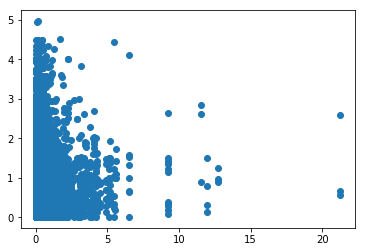

In [37]:
import matplotlib.pyplot as plt
plt.scatter(test['count'],test['residual'])

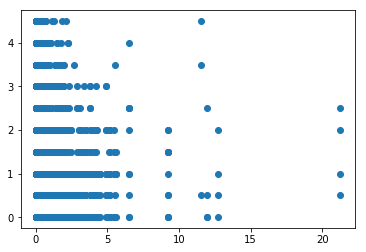

In [30]:

plt.scatter(test['count'],test['residual_first'])

In [44]:
len(train_raw[train_raw.userId==1]),len(test[test.userId==1])

(16, 4)

In [45]:
test.groupby('userId').count()[['movieId']].rename(columns={'movieId':'count'}).reset_index()

,userId,count
0,1.0,4
1,2.0,16
2,3.0,11
3,4.0,41
4,5.0,20
5,6.0,9
6,7.0,18
7,8.0,24
8,9.0,9
9,10.0,10
